In [1]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=984fcf399f6c111e7b63de3ca127f240752b6b9313d6745cdb10bdff6142bd7d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

In [2]:
import roboflow
from roboflow import Roboflow
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
rf = Roboflow(api_key="dJDF7c8zszBIMe30c1pC")
project = rf.workspace("ivan-cvk3z").project("birds-uojom")
dataset = project.version(2).download("multiclass")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to birds-2 in multiclass:: 100%|██████████| 277/277 [00:00<00:00, 507.55it/s]


In [4]:
# lendo o arquivo com os dados
df_test = pd.read_csv('/content/birds-2/test/_classes.csv', encoding='utf-8')
df_train = pd.read_csv('/content/birds-2/train/_classes.csv', encoding='utf-8')
df_valid = pd.read_csv('/content/birds-2/valid/_classes.csv', encoding='utf-8')

In [5]:
df_test.columns = ['filename', 'apteryx_australis', 'Birds', 'casuarius_casuarius', 'tinamus_tao']
df_train.columns = ['filename', 'apteryx_australis', 'Birds', 'casuarius_casuarius', 'tinamus_tao']
df_valid.columns = ['filename', 'apteryx_australis', 'Birds', 'casuarius_casuarius', 'tinamus_tao']

In [6]:
# removendo a coluna "birds"
df_test = df_test.drop(columns=['Birds'])
df_train = df_train.drop(columns=['Birds'])
df_valid = df_valid.drop(columns=['Birds'])

# deletando a linha 22 por estar com um dado faltante
df_test.drop(22, inplace=True)

# juntando os datasets de treino e teste
# df = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
# Ajuste do nome das colunas, estava dando problema para leituras

df_train['category'] = ''

for index, row in df_train.iterrows():
    if row['apteryx_australis'] == 1:
        df_train.at[index, 'category'] = 'apteryx_australis'
    elif row['casuarius_casuarius'] == 1:
        df_train.at[index, 'category'] = 'casuarius_casuarius'
    else:
        df_train.at[index, 'category'] = 'tinamus_tao'

In [8]:
# Ajuste do nome das colunas, estava dando problema para leituras

df_test['category'] = ''

for index, row in df_test.iterrows():
    if row['apteryx_australis'] == 1:
        df_test.at[index, 'category'] = 'apteryx_australis'
    elif row['casuarius_casuarius'] == 1:
        df_test.at[index, 'category'] = 'casuarius_casuarius'
    else:
        df_test.at[index, 'category'] = 'tinamus_tao'

In [9]:
# Ajuste do nome das colunas, estava dando problema para leituras

df_valid['category'] = ''

for index, row in df_valid.iterrows():
    if row['apteryx_australis'] == 1:
        df_valid.at[index, 'category'] = 'apteryx_australis'
    elif row['casuarius_casuarius'] == 1:
        df_valid.at[index, 'category'] = 'casuarius_casuarius'
    else:
        df_valid.at[index, 'category'] = 'tinamus_tao'

In [10]:
# Define as dimensões da imagem e o tamanho do batch
img_size = (640, 640)
batch_size = 32

# Define um gerador de imagens para normalizar e redimensionar as imagens
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
# Cria um gerador de dados de treinamento a partir do DataFrame
train_ds = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='/content/birds-2/train',
    x_col='filename',
    y_col='category',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

train_labels = train_ds.labels
train_y = to_categorical(train_labels, num_classes=len(train_ds.class_mode))

Found 187 validated image filenames belonging to 3 classes.


In [12]:
# Cria um gerador de dados de validação a partir do DataFrame
valid_ds = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory='/content/birds-2/valid',
    x_col='filename',
    y_col='category',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

valid_labels = valid_ds.labels
valid_y = to_categorical(valid_labels, num_classes=len(valid_ds.class_mode))

Found 53 validated image filenames belonging to 3 classes.


In [13]:
# Cria um gerador de dados de teste a partir do DataFrame
test_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='/content/birds-2/test',
    x_col='filename',
    y_col='category',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_labels = test_ds.labels
test_y = to_categorical(test_labels, num_classes=len(test_ds.class_mode))


Found 28 validated image filenames belonging to 3 classes.


In [14]:
# Carrega o modelo ResNet50 pré-treinado
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))

# Congela as camadas de base_model para que elas não sejam treinadas novamente
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
# Adiciona camadas adicionais ao modelo
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(df_train['category'].unique()), activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compila o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treina o modelo nos dados de treinamento e avalia-o nos dados de validação

history = model.fit(train_ds, epochs=10, validation_data=valid_ds)

# Salva o history em um arquivo CSV

df_history = pd.DataFrame(history.history)
df_history.to_csv('history.csv', index=False)

Epoch 1/10
6/6 [==============================] - 45s 4s/step - loss: 1.2241 - accuracy: 0.5187 - val_loss: 0.5112 - val_accuracy: 0.8113
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.5065 - accuracy: 0.7807 - val_loss: 0.4855 - val_accuracy: 0.8491
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.3436 - accuracy: 0.8877 - val_loss: 0.3709 - val_accuracy: 0.8302
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 0.2588 - accuracy: 0.9358 - val_loss: 0.3069 - val_accuracy: 0.9245
Epoch 5/10
6/6 [==============================] - 8s 1s/step - loss: 0.2120 - accuracy: 0.9519 - val_loss: 0.2342 - val_accuracy: 0.9245
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.1853 - accuracy: 0.9412 - val_loss: 0.3016 - val_accuracy: 0.9057
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 0.1305 - accuracy: 0.9572 - val_loss: 0.2089 - val_accuracy: 0.9623
Epoch 8/10
6/6 [========================

In [16]:
# Salva o modelo em SavedModel format
tf.saved_model.save(model, 'meu_modelo_salvo/')

In [ ]:
# Avalia o modelo nos dados de teste
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


1/1 [==============================] - 1s 1s/step - loss: 0.0583 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 0.058346349745988846


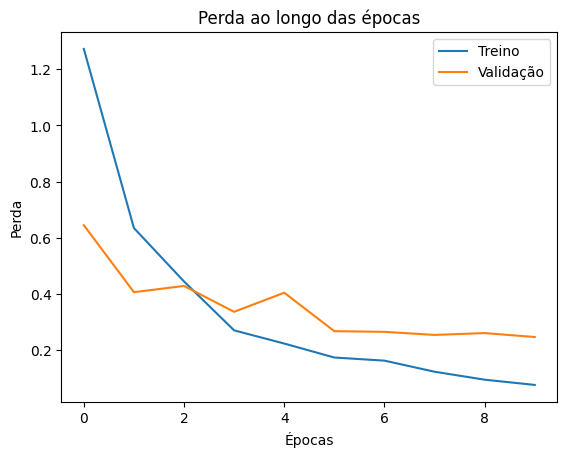

In [ ]:
# Salva as perdas em arrays separados para treino e validação
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Cria o gráfico
plt.plot(train_loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.title('Perda ao longo das épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

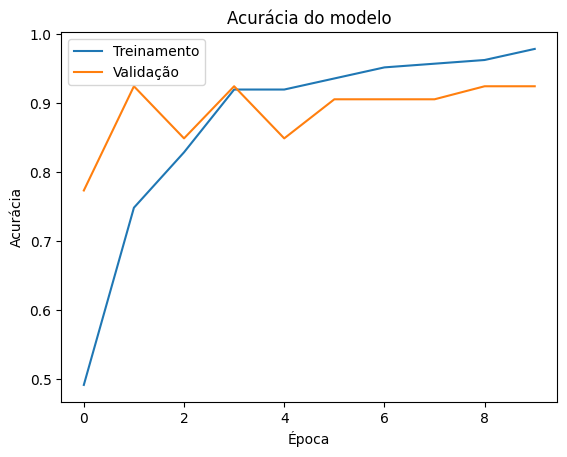

In [ ]:
# Plota o gráfico de acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()